## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.model_selection import (train_test_split,
                                     cross_val_score)
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (mean_squared_error,
                             make_scorer)

!pip install shap
import shap

!pip install category_encoders
from category_encoders import MEstimateEncoder

!pip install catboost
from catboost import CatBoost, cv, CatBoostRegressor, Pool

!pip install lightgbm
import lightgbm as lgb


!pip install missingno
import missingno as msno

import time
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 547 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 10 kB/s  eta 0:00:011


In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df_first = df.copy()

In [6]:
df.columns= df.columns.str.strip().str.lower()

In [7]:
df['datecrawled'].max()

'2016-04-07 14:36:58'

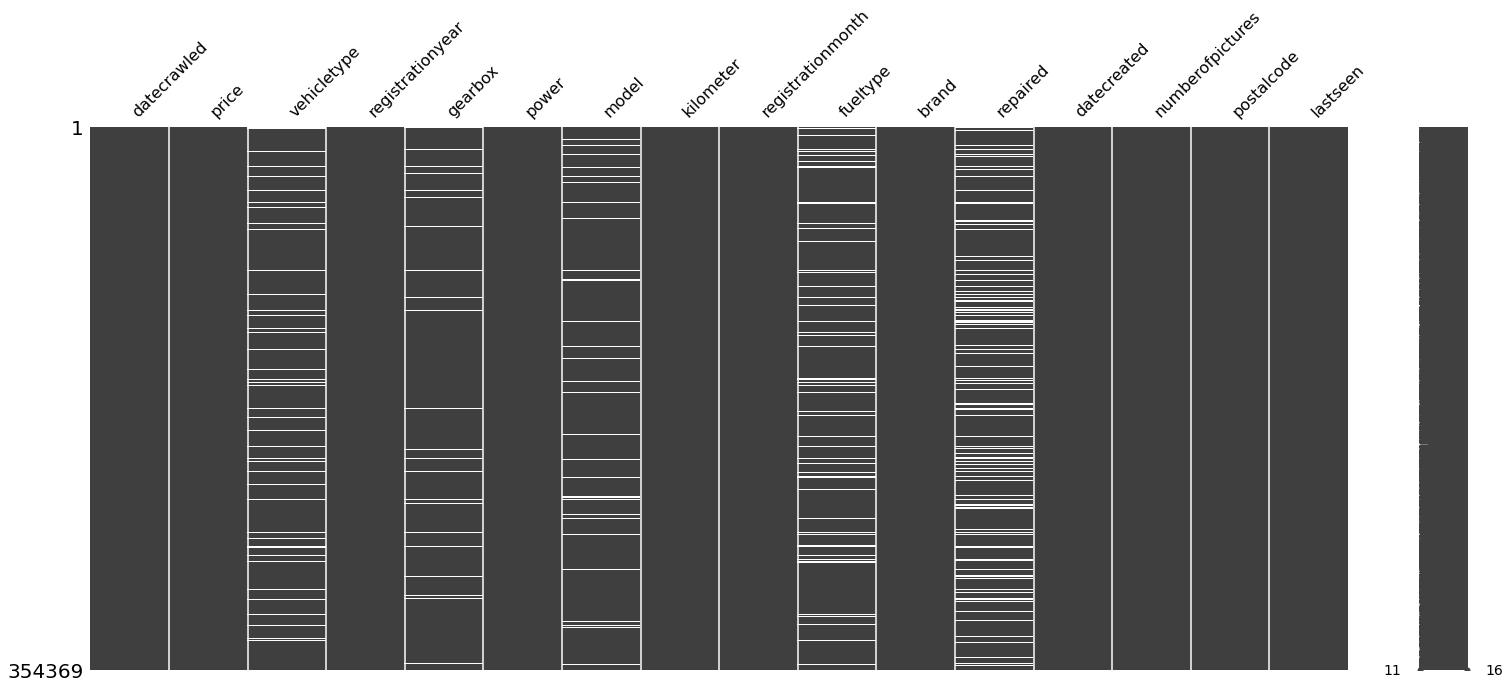

<Figure size 1080x648 with 0 Axes>

In [8]:
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

In [9]:
numeric_column = ['power', 'kilometer', 'registrationyear','price']
df_numeric = df[numeric_column]

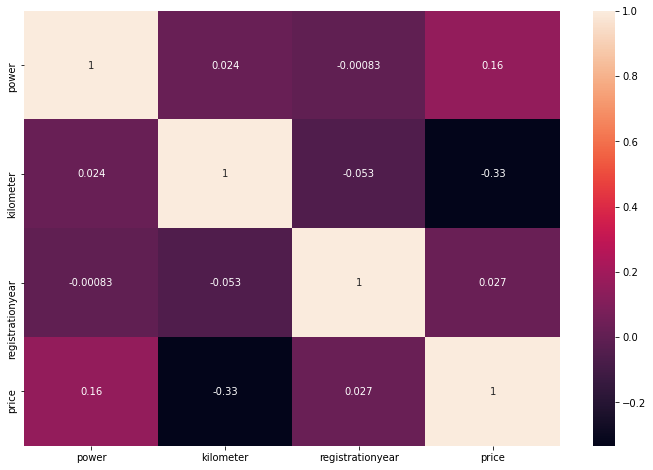

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot = True);

In [11]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

In [12]:
get_numerical_summary(df)

vehicletype : 37490 (10.579%)
gearbox : 19833 (5.597%)
model : 19705 (5.561%)
fueltype : 32895 (9.283%)
repaired : 71154 (20.079%)


{'vehicletype': 10.57936783409384,
 'gearbox': 5.596708515699737,
 'model': 5.560587974681758,
 'fueltype': 9.282696849893755,
 'repaired': 20.079070121822166}

In [13]:
cat_missing_cols = [col for col in df if df[col].dtype == 'object']
df[cat_missing_cols] = df[cat_missing_cols].fillna('missing')

In [14]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [15]:
columns_to_drop = ['datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen']
df = df.drop(columns_to_drop, axis=1)

In [16]:
df.describe()

,price,registrationyear,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


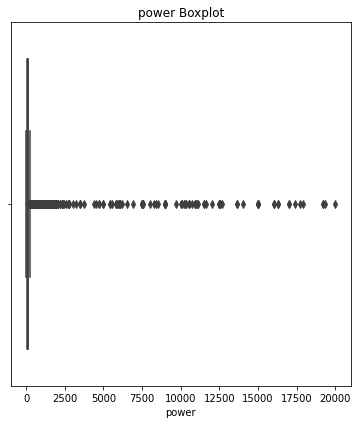

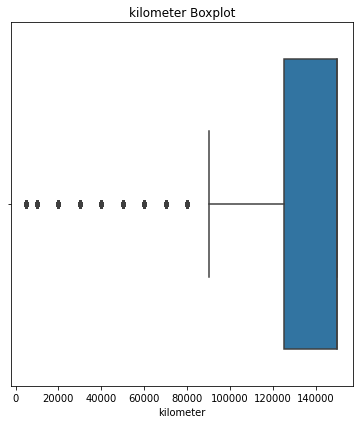

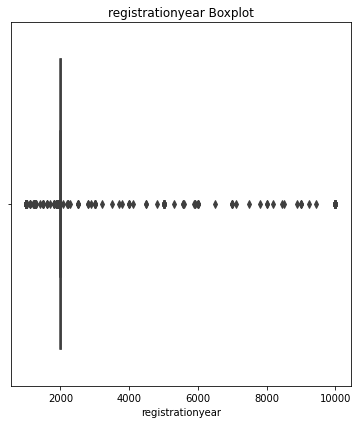

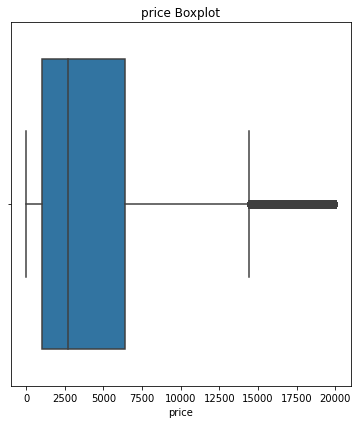

In [17]:
for column in numeric_column:
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f"{column} Boxplot")
    
    plt.tight_layout()
    plt.show()

In [18]:
df = df.drop(df[(df['power'] < 20) | (df['power'] > 500)].index)

In [19]:
np.sort(df["registrationyear"].unique())

array([1000, 1234, 1500, 1800, 1910, 1927, 1928, 1929, 1930, 1931, 1933,
       1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2800, 2900, 3000, 3500, 4000,
       4500, 5000, 5911, 6000, 6500, 8000, 8200, 9000, 9999])

In [20]:
df[df["registrationyear"] == 1955]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
3333,10500,sedan,1955,manual,30,other,60000,petrol,ford,missing
12993,11000,other,1955,manual,40,missing,50000,petrol,sonstige_autos,no
64872,11800,sedan,1955,manual,56,other,60000,petrol,citroen,no
109349,12800,sedan,1955,auto,220,missing,100000,petrol,sonstige_autos,yes
171996,500,bus,1955,manual,67,missing,5000,missing,sonstige_autos,no
186403,18900,other,1955,manual,220,other,10000,petrol,chevrolet,no
199144,19950,sedan,1955,manual,45,other,10000,petrol,opel,missing
219940,4999,sedan,1955,manual,22,other,20000,petrol,opel,no
316508,9700,wagon,1955,manual,75,other,150000,petrol,opel,no


In [21]:
df = df.drop(df[(df["registrationyear"] < 1955) | (df['registrationyear'] > 2016)].index)

In [22]:
df['kilometer'].value_counts()

150000    201414
125000     32241
100000     13007
90000      10427
80000       9131
70000       7862
60000       6864
50000       5685
40000       4523
30000       3931
20000       3287
5000        3124
10000        925
Name: kilometer, dtype: int64

- По какой то причине 2/3 всего датасета имеет пробег ровно 150000

In [23]:
df.groupby(['registrationyear', 'kilometer'])['kilometer'].count()

registrationyear  kilometer
1955              5000            1
                  10000           2
                  20000           1
                  50000           1
                  60000           2
                               ... 
2016              80000         111
                  90000         141
                  100000        199
                  125000        554
                  150000       5189
Name: kilometer, Length: 763, dtype: int64

In [24]:
df[df['registrationyear'] == 2016]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
16,300,missing,2016,missing,60,polo,150000,petrol,volkswagen,missing
31,899,missing,2016,manual,60,clio,150000,petrol,renault,missing
35,350,missing,2016,manual,75,golf,150000,petrol,volkswagen,no
52,1400,missing,2016,manual,55,other,5000,missing,hyundai,missing
79,150,missing,2016,manual,75,astra,150000,petrol,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354068,3700,missing,2016,manual,90,golf,150000,gasoline,volkswagen,missing
354100,600,missing,2016,manual,170,vectra,150000,petrol,opel,yes
354107,395,missing,2016,manual,60,golf,150000,petrol,volkswagen,missing
354115,299,missing,2016,manual,60,astra,150000,petrol,opel,yes


- почти все машины 2016 года имеют пробег 125к + км что очень странно учитывая что наш датасет примерно тех же лет хмм
- по исследованиям 2022 года: Средний пробег автомобиля по России в 2022 году составляет 18,7 тыс. км

In [25]:
df.query('brand == "bmw" & model == "1er" & registrationyear == 2016')

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
751,9000,missing,2016,manual,122,1er,80000,petrol,bmw,no
1022,8500,missing,2016,manual,177,1er,150000,missing,bmw,no
26460,13500,missing,2016,manual,122,1er,40000,petrol,bmw,missing
56227,8000,missing,2016,manual,122,1er,80000,petrol,bmw,no
61442,0,missing,2016,manual,170,1er,125000,gasoline,bmw,missing
62617,13599,coupe,2016,manual,102,1er,80000,petrol,bmw,no
65093,1699,missing,2016,manual,101,1er,150000,petrol,bmw,missing
77668,7000,missing,2016,manual,170,1er,80000,petrol,bmw,yes
79810,10750,missing,2016,manual,143,1er,150000,gasoline,bmw,missing
84124,6750,missing,2016,manual,122,1er,150000,gasoline,bmw,missing


- на первый взгляд почти все значения заполнены 125к и 150к на прайсе пробежавшись глазами это никак не отражается, это очивидно аномалия т.к. 2200 из 2900 годовалых машин с пробегом 150к быть не может. Попробуй оставить столбец как есть и обучить модель, так же попробуем обучить модель удалив этот столбец.

In [26]:
df = df.drop(df[df["price"] <= 500].index)

In [27]:
df.reset_index(drop = True,inplace=True)

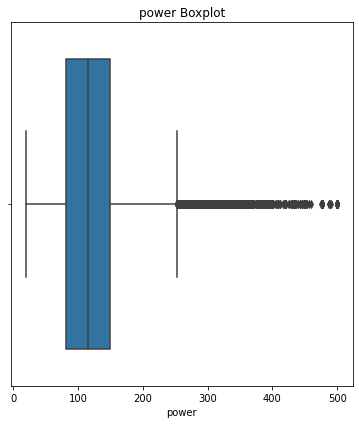

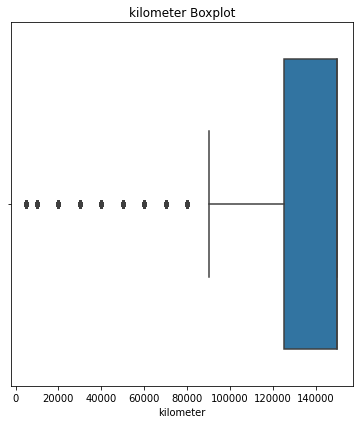

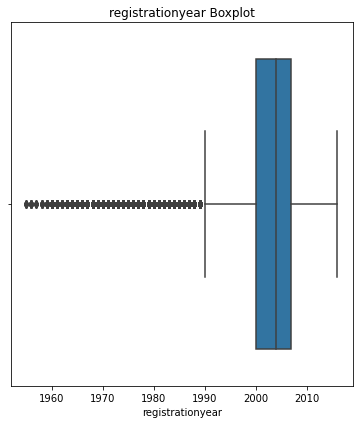

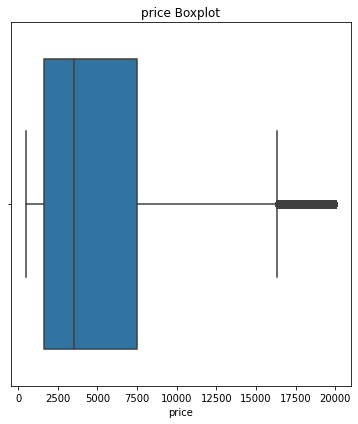

In [28]:
for column in numeric_column:
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f"{column} Boxplot")
    
    plt.tight_layout()
    plt.show()

In [29]:
1 - len(df) / len(df_first)

0.2252962307651064

In [30]:
df.describe()

,price,registrationyear,power,kilometer
count,274531.000000,274531.000000,274531.000000,274531.000000
mean,5206.633535,2003.180930,123.584714,127557.871424
std,4603.198471,6.355542,53.522977,36971.270443
min,501.000000,1955.000000,20.000000,5000.000000
25%,1600.000000,2000.000000,82.000000,125000.000000
50%,3500.000000,2004.000000,116.000000,150000.000000
75%,7499.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,500.000000,150000.000000


### Вывод предобработки данных.

- Избавляясь от аномалий мы пожертвовали 20% данных что не мало.

- Аномалия с пробегам пока без изменений, напомню 2/3 датасета имеют пробег в 150000 тысяч, а машины 2018 (машине на момент создания датасета всего 1 год) 2200 машин из 2900 бмв 1-серии имеют пробег 150000 что на мой взгляд является ошибкой в данных.

- Устранены аномалии в столбцах price, kilometer, registraishonyear.

- Пропуски обнаружены только в категориальных переменных и были заполнены missing

- Сильной корреляции между целевой переменной и другими количественными переменными не обнаружено.

## Обучение моделей

In [31]:
RS = 42

In [32]:
X = df.drop('price', axis = 1)
y = df['price']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

In [34]:
scale_col = ['power', 'registrationyear', 'kilometer']

In [35]:
scaler = StandardScaler()
X_train[scale_col] = scaler.fit_transform(X_train[scale_col])
X_test[scale_col] = scaler.transform(X_test[scale_col])

In [36]:
df.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'repaired'],
      dtype='object')

In [37]:
cat_names = ['vehicletype','gearbox', 'model',
             'fueltype', 'brand', 'repaired']

### Catboost regressor

In [38]:
params = {'loss_function':'RMSE', 'verbose': 100, 'random_seed': RS}

In [39]:
train_pool = Pool(X_train, 
                  label=y_train,
                  cat_features=cat_names)
test_pool = Pool(X_test, 
                  label=y_test,
                  cat_features=cat_names)

In [40]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-RMSE-mean'].min()
    best_iter = cv_data['test-RMSE-mean'].values.argmin()

    print('Best validation RMSE score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-RMSE-std'][best_iter],
        best_iter)
    )

In [41]:
#cat_model.save_model('cat_model.cbm')
#cat_model.load_model('cat_model.cbm')

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

print_cv_summary(cv_data)

**RMSE: 1688.6211698534373**

**Время выполнения кросс валидации +- 12 минут (около 3 минут на один фолд)**

**Результаты были достигнуты при использовании параметров catboost по умолчанию:**


- iterations: 1000
- learning_rate: 0.03
- depth: 6
- l2_leaf_reg: 3

попробуем изменить параметры

In [42]:
params_v2 = {
    'objective': 'regression',
    'loss_function': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05
}

In [43]:
cat_model_v2 = CatBoostRegressor(**params_v2)

cv_data_v2 = cv(
    params = params_v2,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

- Закомментировал т.к. выполняется 10+ минут - результаты приложу ниже.

In [44]:
#cat_model_v2.save_model('cat_model_v2.cbm')
#cat_model_v2.load_model('cat_model_v2.cbm')

**RMSE: 1746.1237386775445**

**Время выполнения кросс валидации +- 11 минут**

**Результаты были достигнуты при использовании параметров catboost:**


- iterations: 1000
- learning_rate: 0.05
- depth: 3
- l2_leaf_reg: 3


### LightGBM regressor

In [45]:
X_train[cat_names] = X_train[cat_names].astype('category')
X_test[cat_names] = X_test[cat_names].astype('category')

In [46]:
X_train

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
83309,small,-0.185025,manual,0.681654,polo,0.606387,gasoline,volkswagen,missing
143211,coupe,-1.600876,manual,0.494578,3er,0.606387,petrol,bmw,yes
254868,wagon,-0.342342,manual,0.139135,passat,0.606387,gasoline,volkswagen,no
171752,bus,-0.342342,manual,0.026890,zafira,-2.367087,petrol,opel,no
88192,coupe,-1.286242,manual,-0.440798,3er,0.606387,petrol,bmw,missing
...,...,...,...,...,...,...,...,...,...
119879,coupe,-0.027708,auto,2.009889,3er,0.606387,petrol,bmw,no
259178,small,-0.027708,auto,-1.170392,fortwo,-1.015508,petrol,smart,no
131932,suv,0.286925,auto,4.142548,missing,0.606387,lpg,sonstige_autos,no
146867,sedan,-0.971609,manual,-0.160185,mondeo,-0.745192,petrol,ford,no


In [47]:
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_names,free_raw_data=False)
lgb_test = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_names,free_raw_data=False)

In [48]:
params_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'force_row_wise': True
}

In [49]:
%%time

cv_results = lgb.cv(params_lgb, lgb_train, num_boost_round=100,
                    nfold=5, stratified=False, shuffle=True,
                    metrics='rmse', early_stopping_rounds=10,
                    verbose_eval=50)


print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['rmse-mean']))
print('Best CV score:', np.min(cv_results['rmse-mean']))

[50]	cv_agg's rmse: 1665.24 + 8.977
[100]	cv_agg's rmse: 1611.21 + 9.83133
Current parameters:
 {'loss_function': 'RMSE', 'verbose': 100, 'random_seed': 42}

Best num_boost_round: 100
Best CV score: 1611.2145922514962
CPU times: user 16.8 s, sys: 53 ms, total: 16.9 s
Wall time: 16.9 s


In [50]:
#lgb_model.save_model('lgb_model.txt')

In [51]:
#lgb_model = lgb.Booster(model_file='lgb_model.txt')

**RMSE: 1622.796667156757**

**Время кросс-валидации: 28min. 13s**

**Результаты были достигнуты при использовании параметров LightGBM:**

    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'force_row_wise': True

попробуем изменить параметры

In [52]:
params_v2 = {
    'objective': 'regression',
    'metric': 'RMSE',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    "max_depth": 8,
}

%%time

cv_results_v2 = lgb.cv(params_v2, lgb_train, num_boost_round=100,
                    nfold=5, stratified=False, shuffle=True,
                    metrics='rmse', early_stopping_rounds=10,
                    verbose_eval=50)


print('Current parameters:\n', params_v2)
print('\nBest num_boost_round:', len(cv_results['rmse-mean']))
print('Best CV score:', np.min(cv_results['rmse-mean']))

- Код в ячейке markdown по той же причине

In [53]:
#lgb_model_v2.save_model('lgb_model_v2.txt')

In [54]:
#lgb_model_v2 = lgb.Booster(model_file='lgb_model_v2.txt')

**RMSE: 1649.9252501209253**

**Результаты были достигнуты при использовании параметров LightGBM:**

- 'objective': 'regression',
- 'metric': 'RMSE',
- 'learning_rate': 0.01,
- 'feature_fraction': 0.9,
- "max_depth": 8,

**LightGBM и CatBoost могут работать с категориальными переменными "Из под капота", для дерева решений такой способ не подойдет, используем One Hot Encoder**

### DecisionTreeRegressor

In [55]:
ohe_names = ['vehicletype','gearbox',
             'fueltype','repaired']
me_names = ['model', 'brand']

In [56]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [57]:
def encode_data(X_train, X_test, ohe_names, me_names):
    encoder_ohe = OneHotEncoder()
    X_train_ohe = encoder_ohe.fit_transform(X_train[ohe_names])
    X_test_ohe = encoder_ohe.transform(X_test[ohe_names])
    X_train_ohe_array = X_train_ohe.toarray()
    X_test_ohe_array = X_test_ohe.toarray()
    X_train_ohe_df = pd.DataFrame(X_train_ohe_array, columns=encoder_ohe.get_feature_names(ohe_names))
    X_test_ohe_df = pd.DataFrame(X_test_ohe_array, columns=encoder_ohe.get_feature_names(ohe_names))
    
    encoder_me = MEstimateEncoder()
    X_train_me = encoder_me.fit_transform(X_train[me_names], y_train)
    X_test_me = encoder_me.transform(X_test[me_names])
    X_train_me_df = X_train_me.add_suffix('_m_estimate')
    X_test_me_df = X_test_me.add_suffix('_m_estimate')
    
    X_train_encoded = pd.concat([X_train.drop(columns=ohe_names+me_names), X_train_ohe_df, X_train_me_df], axis=1)
    X_test_encoded = pd.concat([X_test.drop(columns=ohe_names+me_names), X_test_ohe_df, X_test_me_df], axis=1)
    
    return X_train_encoded, X_test_encoded

In [58]:
X_train_encode, X_test_encode = encode_data(X_train, X_test,ohe_names,me_names)

In [59]:
tree_model = DecisionTreeRegressor(random_state = RS)

In [60]:
%%time

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

tree_cv = cross_val_score(tree_model, X_train_encode, y_train, cv=5, scoring=rmse_scorer)

print("Средняя RMSE на кросс-валидации: {:.2f}".format(-tree_cv.mean()))

Средняя RMSE на кросс-валидации: 1901.30
CPU times: user 4.76 s, sys: 85.7 ms, total: 4.85 s
Wall time: 4.85 s


In [61]:
tree_model_v2 = DecisionTreeRegressor(max_depth=5, min_samples_split = 3)

In [62]:
%%time

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

tree_cv = cross_val_score(tree_model_v2, X_train_encode, y_train, cv=5, scoring=rmse_scorer)

print("Средняя RMSE на кросс-валидации: {:.2f}".format(-tree_cv.mean()))

Средняя RMSE на кросс-валидации: 2424.75
CPU times: user 1.41 s, sys: 29.8 ms, total: 1.44 s
Wall time: 1.44 s


**Посмотрим как повлияет на метрику столбец kilometer**

In [63]:
X_train_km = X_train_encode.drop('kilometer', axis=1)

In [64]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

tree_cv = cross_val_score(tree_model, X_train_km, y_train, cv=5, scoring=rmse_scorer)

print("Средняя RMSE на кросс-валидации: {:.2f}".format(-tree_cv.mean()))

Средняя RMSE на кросс-валидации: 1976.26


Результат обучения до удаления признака RMSE = 1901.30, после удаления RMSE = 1976.26 все таки фича значимая

### Вывод

**Дерево решений**

- В данной задаче дерево решений на настройках по умолчанию переобучилось, но тем не менее смогло показать неплохой результат, при изменении настроек - результат значимо ухудшился.

- Тем не менее скорость обучения и предсказания у алгоритма на высоте.
------
**Catboost**

- Второй результат RMSE 

- Обучается дольше чем lightGBM, быстрее предсказывает, но с худшим результатом.
-----
**LightGBM**

- Лучший результат RMSE 

- Среднее время обучения и довольно долгое время предсказания.
-----

LightGBM в нашем случае забирает 2/3 номинаций, выберем данный алгоритм для дальнейшей проверки.

- Оценка не актуальна тк тестировались параметры модели на кросс-валидации лучший скор показала опять же LightGBM но скорость кросс валидации у нее оказалась чуть ли не в два раза выше чем у catboost


- Дерево решений показало низкие результаты RMSE которые не идут в сравнение с конкурентами

## Анализ моделей

In [65]:
%%time 

final_model = lgb.train(params_lgb, lgb_train,
                        num_boost_round=1000,
                        valid_sets=[lgb_test], early_stopping_rounds=10)

[1]	valid_0's rmse: 4260.62
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 3958.66
[3]	valid_0's rmse: 3696.13
[4]	valid_0's rmse: 3461.84
[5]	valid_0's rmse: 3257.03
[6]	valid_0's rmse: 3073.67
[7]	valid_0's rmse: 2915.23
[8]	valid_0's rmse: 2775.47
[9]	valid_0's rmse: 2647.87
[10]	valid_0's rmse: 2534.87
[11]	valid_0's rmse: 2435.15
[12]	valid_0's rmse: 2347.03
[13]	valid_0's rmse: 2269.34
[14]	valid_0's rmse: 2201.72
[15]	valid_0's rmse: 2140.24
[16]	valid_0's rmse: 2087.46
[17]	valid_0's rmse: 2043.12
[18]	valid_0's rmse: 2001.06
[19]	valid_0's rmse: 1963.76
[20]	valid_0's rmse: 1931.34
[21]	valid_0's rmse: 1902.41
[22]	valid_0's rmse: 1877.52
[23]	valid_0's rmse: 1855.66
[24]	valid_0's rmse: 1834.73
[25]	valid_0's rmse: 1815.51
[26]	valid_0's rmse: 1798.41
[27]	valid_0's rmse: 1783.39
[28]	valid_0's rmse: 1769.38
[29]	valid_0's rmse: 1756.51
[30]	valid_0's rmse: 1744.7
[31]	valid_0's rmse: 1734.62
[32]	valid_0's rmse: 1724.54
[33]	valid_0's rmse: 

In [66]:
final_model.save_model('final_model_car_price.txt')

In [67]:
%%time

y_pred = final_model.predict(X_test)

print('RMSE:', rmse(y_test,y_pred))

RMSE: 1495.3256379587842
CPU times: user 5.76 s, sys: 0 ns, total: 5.76 s
Wall time: 5.77 s


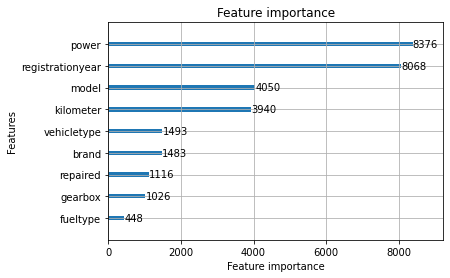

In [68]:
lgb.plot_importance(final_model, max_num_features=10)
plt.show()

In [69]:
%%time 
shap_values = shap.TreeExplainer(final_model).shap_values(X_test)

CPU times: user 9min 52s, sys: 384 ms, total: 9min 53s
Wall time: 9min 55s


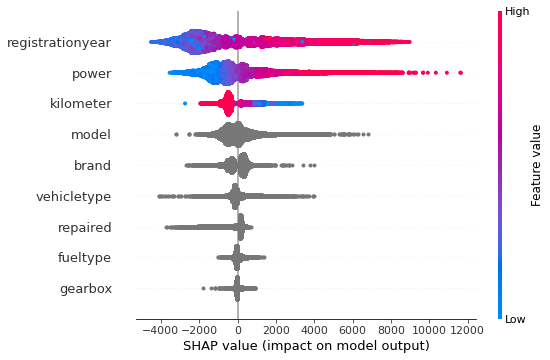

In [70]:
shap.summary_plot(shap_values, X_test)

- Год выпуска автомобиля и мощность отражаются как наиболее значимые фичи, мощность я думаю попала сюда как комплексная фича ведь по сути мощность авто отражает так же и уровень комплектации, если зайти в конфигуратор бмв то у более мощных версий модели уже по умолчанию стоят дорогие опции

### Результаты выбранного алгоритма

- Библиотека - LightGBM


- RMSE на cross_val: 1622.796667156757


- RMSE на test: 1495.3256379587842


- Время обучения 1h 48s


- Время предсказания test 7.57 s